# Goals of this project
The aim of this project was to act as a simple exploratory project to practice building a fairly fundamental tool in NLP.

I learned the concepts behind the word2vec model, and while it was fairly understandable I wanted to see how it would translate to code.

I also got to practice working more with the pytorch library as a result, which was a big win.

The biggest challenge for me in building this was getting the vector dimensions right for matrix multiplication. Learning to respect that process and approach it slowly was valuable.



In [249]:
import re
import random
import torch.nn as nn
import torch
import numpy as np
from fastcore import *
from nbdev.showdoc import *
from tqdm import tqdm
import pickle as pkl

## Data ingestion
Here we define some functions for reading in and cleaning the data.

The primary data cleaning involves removing any characters which aren't letters as well making all those letters lowercase. 
We also remove all whitespace except for single spaces between words.

We want to remove words which do not carry much semantic weight on their own, which we will call stop words. We simply filter these out of the data.

In [272]:
def read_file(file_name):
    with open(file_name, 'r') as f:
        data = f.read()
    return data

def remove_non_alpha_characters(data):
    data = data.lower()
    # use regex to remove all non-alphanumeric characters
    data = re.sub(r'[^a-zA-Z\s]', '', data)
    # use regex to remove all whitespace characters
    data = re.sub(r'\s+', ' ', data)
    return data


def remove_stopwords(data):
    stopwords = ['a', 'an', 'the', 'and', 'or', 'but', 'if', 'then', 'else', 'when', 'at', 'from', 'by', 'on', 'off', 'for', 'in', 'out', 'over', 'to', 'into', 'with', ""]
    data = [word for word in data if word not in stopwords]
    return data


In [273]:
raw_data = read_file('shakespeare.txt')

data = remove_non_alpha_characters(raw_data)
data = data.split(" ")
data = remove_stopwords(data)

Here we create our dictionary of unique words which we will use for defining our embeddings.

We make this into a dictionary so that later we can refer to these values and get an index from each one.

In [274]:
unique_words = set(list(data))
unique_dict = {word: i for i, word in enumerate(unique_words)}

### Create a train loader and dataset
Here we create a train_loader that will randomly generate samples for us to use during training.

We choose a large batch size as this task does not demand a great deal of memory and larger batches help with training speed.

We define only the functions here and call them later so that all hyper parameters can be defined and run in one place.


In [277]:
def return_list_without_a_value(data, value):
    return [x for x in data if x != value]

def create_dataset(window_size, data):
    dataset = []

    for index, val in enumerate(data):
        sub = data[max(0,index-window_size):index]
        sub.extend(data[index+1:min(index+window_size, len(data))])
        for target in sub:
            dataset.append((unique_dict[val],unique_dict[target]))
    return dataset  

def create_dataloader(dataset, batch_size):
    train_loader = torch.utils.data.DataLoader(dataset=dataset, 
                                           batch_size=batch_size, 
                                           shuffle=True)
    return train_loader


## Defining our model

Here we define our skipgram model class.

We take advantage of the built in pytorch module and embedding class to create our vector embeddings and handle the updating of our embedding weights.

Our embeddings are essentially just matrices with dimensions matching the size of our dictionary and the embedding size we choose to represent the different features that will emerge from our data.

One thing to take note of is how we initialise our weights. Currently we simply use a normal distribution with a mean of 0 and std_deviation of 0.1. It is possible there are better initialisations to use here.
We also use sparse embeddings many many of the values will be very close to, or at 0.


In [256]:
class SkipGramModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim):
        super(SkipGramModel, self).__init__()
        self.vocab_size = vocab_size
        self.embedding_dim = embedding_dim
        self.u_embeddings = nn.Embedding(vocab_size, embedding_dim, sparse=True)
        self.v_embeddings = nn.Embedding(vocab_size, embedding_dim, sparse=True)
        self.init_emb()

    def init_emb(self):
        init_mean = 0
        init_std = 0.1
        self.u_embeddings.weight.data.normal_(init_mean, init_std)
        self.v_embeddings.weight.data.normal_(init_mean, init_std)

    def forward(self, pos_u, pos_v, neg_v):
        # Precompute embeddings for pos_u and pos_v
        emb_u = self.u_embeddings(pos_u).view(-1, 1, self.embedding_dim).squeeze()
        emb_v = self.v_embeddings(pos_v).view(-1, self.embedding_dim).squeeze()

        # Compute score for pos_u and pos_v
        score = torch.bmm(emb_u.unsqueeze(1), emb_v.unsqueeze(2)).squeeze()
        score = torch.sigmoid(score)

        # Precompute embeddings for neg_v
        neg_emb_v = self.v_embeddings(neg_v).view(-1, self.embedding_dim, neg_v.shape[1])

        # Compute scores for neg_v
        neg_score = torch.bmm(emb_u.unsqueeze(1), neg_emb_v).squeeze()
        neg_score = torch.sigmoid(neg_score)

        return score, neg_score


    
    def forward_without_negatives(self, word1, word2):
        pos_u = torch.tensor([unique_dict[word1]])
        pos_v = torch.tensor([unique_dict[word2]])
        emb_u = self.u_embeddings(pos_u).view(-1, 1, self.embedding_dim).squeeze()
        emb_v = self.v_embeddings(pos_v).view(-1, self.embedding_dim).squeeze()
        score = torch.dot(emb_u, emb_v)
        score = torch.sigmoid(score)
        return score

    def get_dict_embeddings(self):
        return self.u_embeddings.weight.data.cpu().numpy()
    
    def get_embedding_from_word(self, word):
        index = unique_dict[word]
        return self.u_embeddings.weight.data[index]
    
    def get_embedding_from_index(self, index):
        return self.u_embeddings.weight.data[index]

    def save_embedding(self, file_name):
        # Save embedding lookup table as pkl file
        with open(file_name, 'wb') as f:
            pkl.dump(self.u_embeddings.weight.data.cpu().numpy(), f)
    
    def import_embeddings(self, file_name):
        with open(file_name, 'rb') as f:
            self.u_embeddings.weight.data = torch.from_numpy(pkl.load(f)).to(torch.float32)
            self.v_embeddings.weight.data = torch.from_numpy(pkl.load(f)).to(torch.float32)




## Instantiating our model



In [ ]:
embedding_dim = 100
dictionary_length = len(unique_words)
model = SkipGramModel(dictionary_length, embedding_dim)

### Loss function
Here we create a custom loss function which gives us a loss based on the model's error when predicting a 1 or 0 for the context word or randomly sampled words.

We use a custom loss function because it allows us to add weight decay to our training and capture the specific nature of what we want the model to improve at, which in this case is relatedness of words.


In [257]:

def loss_function(score, neg_score, lr, weight_decay, model):
    pos_loss = -torch.mean(torch.log(score))
    neg_loss = -torch.mean(torch.sum(torch.log(1 - neg_score), dim=1))
    loss = pos_loss + neg_loss
    # add L2 regularization term
    l2_loss = 0
    for param in model.parameters():
        l2_loss += torch.sum(param**2)
        loss += weight_decay * l2_loss
    return loss

## Training loop
This is the training loop for our model.

Our train loader iterator is declared every epoch and we then iterate over it according to our steps per epoch.

We generate our negative samples randomly at runtime as the cost of doing so is very low.

The parameters passed in for training have a massive impact on model performance. 
The length of negative samples should be somewhere between 5 and 20. Having a lower numbers means the model may stray into simply having all of its values tend to 1 which is not what we want. Thus a higher number is favoured.


In [262]:
def train(model, train_loader, batch_size, negative_sample_length, weight_decay, learning_rate, steps_per_epoch, epochs):
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    for epoch in range(epochs):
        loss_sum = 0
        train_loader_iter = iter(train_loader)
        for i in tqdm(range(steps_per_epoch)):
            x, y = next(train_loader_iter)
            pos_u = torch.tensor(x)
            pos_v = torch.tensor(y)
            neg_v = torch.randint(0, dictionary_length, (batch_size, negative_sample_length))
            optimizer.zero_grad()
            pos_score, neg_score = model(pos_u, pos_v, neg_v)
            loss = loss_function(pos_score, neg_score, learning_rate, weight_decay, model)
            loss.backward()
            optimizer.step()
            loss_sum += loss.item()
        print("Epoch: {}, Loss: {}".format(epoch, loss_sum / steps_per_epoch))
    return model


  0%|          | 0/300 [00:00<?, ?it/s]/var/folders/xr/3pxy4p9914ld14l6mxvvknvw0000gn/T/ipykernel_73322/1547006582.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  pos_u = torch.tensor(x)
/var/folders/xr/3pxy4p9914ld14l6mxvvknvw0000gn/T/ipykernel_73322/1547006582.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  pos_v = torch.tensor(y)
100%|██████████| 300/300 [00:05<00:00, 59.86it/s]


Epoch: 0, Loss: 11.096736720403035


100%|██████████| 300/300 [00:04<00:00, 60.90it/s]


Epoch: 1, Loss: 11.10769416809082


100%|██████████| 300/300 [00:04<00:00, 61.24it/s]


Epoch: 2, Loss: 11.112197904586791


100%|██████████| 300/300 [00:04<00:00, 62.67it/s]


Epoch: 3, Loss: 11.126311365763346


100%|██████████| 300/300 [00:04<00:00, 62.41it/s]


Epoch: 4, Loss: 11.120251633326212


100%|██████████| 300/300 [00:04<00:00, 62.22it/s]


Epoch: 5, Loss: 11.119219729105632


100%|██████████| 300/300 [00:04<00:00, 62.34it/s]


Epoch: 6, Loss: 11.115454371770223


100%|██████████| 300/300 [00:04<00:00, 62.84it/s]


Epoch: 7, Loss: 11.107603842417399


100%|██████████| 300/300 [00:04<00:00, 62.32it/s]


Epoch: 8, Loss: 11.105810740788778


100%|██████████| 300/300 [00:04<00:00, 60.81it/s]


Epoch: 9, Loss: 11.097361284891765


100%|██████████| 300/300 [00:04<00:00, 61.08it/s]


Epoch: 10, Loss: 11.0758145682017


100%|██████████| 300/300 [00:04<00:00, 62.53it/s]


Epoch: 11, Loss: 11.065972531636556


100%|██████████| 300/300 [00:04<00:00, 62.40it/s]


Epoch: 12, Loss: 11.070559730529785


100%|██████████| 300/300 [00:04<00:00, 63.18it/s]


Epoch: 13, Loss: 11.069947557449341


100%|██████████| 300/300 [00:04<00:00, 61.84it/s]


Epoch: 14, Loss: 11.077395655314128


SkipGramModel(
  (u_embeddings): Embedding(30997, 100, sparse=True)
  (v_embeddings): Embedding(30997, 100, sparse=True)
)

# Training hyperparameters

The key hyperparameters we choose here are 

In [ ]:
window_size = 5
batch_size = 32
learning_rate = 0.001
negative_sample_length = 15
weight_decay = 0.0006
steps_per_epoch = 300
epochs = 30

dataset = create_dataset(window_size , data) 
train_loader = torch.utils.data.DataLoader(dataset=dataset, 
                                           batch_size=batch_size, 
                                           shuffle=True)

train(model, train_loader, batch_size, negative_sample_length, weight_decay, learning_rate, steps_per_epoch, epochs)

# Testing
We now go to the testing phase to see how our model is performing.

### Testing functions
The following functions primarily exist to add, subtract and compare vectors. The goal is to produce intuitive results from the comparisons of our vectors.

Eg the following should have a high correlation:
flower and rose
man and king

man and woman

queen and woman
#### The following should have a low correlation
Flower and cart

concept and dog

power and table

In [260]:
def subtract_vector(vector1,vector2):
    return get_emb(vector1) - get_emb(vector2)

def add_vector(vector1,vector2):
    return get_emb(vector1) + get_emb(vector2)

def cos_sim(vector1, vector2):
    return np.dot(vector1, vector2) / (np.linalg.norm(vector1) * np.linalg.norm(vector2))

def cos_sim_word(word1, word2):
    vector1 = get_emb(word1)
    vector2 = get_emb(word2)
    return np.dot(vector1, vector2) / (np.linalg.norm(vector1) * np.linalg.norm(vector2))

def get_emb(word):
    return model.get_embedding_from_word(word)

def invert_dictionary(dictionary):
    return {v: k for k, v in dictionary.items()}

def get_closest_vector(vector):
    max = 0
    target = None
    for key,item in unique_dict.items():
        comparative = get_emb(key)
        comparison = cos_sim(vector, comparative)
        if comparison > max:
            max = comparison
            target = key

        
    return target


In [261]:
print(cos_sim_word("flower", "rose"),("flower", "rose"))
print(cos_sim_word("flower", "tree"), ("flower", "tree"))
print(cos_sim_word("flower", "dog"), ("flower", "dog"))
print(cos_sim_word("flower", "metal"), ("flower", "metal"))
print(cos_sim_word("flower", "cart"), ("flower", "cart"))
print(cos_sim_word("worm", "dog"), ("worm", "dog"))
print(cos_sim_word("king", "queen"), ("king", "queen"))
print(cos_sim_word("king", "royalty"), ("king", "royalty"))
print(cos_sim_word("queen", "royalty"), ("queen", "royalty"))
print(cos_sim_word("man", "king"), ("man", "king"))
print(cos_sim_word("woman", "king"), ("woman", "king"))
print(cos_sim_word("woman", "boot"), ("woman", "boot"))
print(cos_sim_word("child", "prince"), ("child", "prince"))
print(cos_sim_word("child", "thought"), ("child", "thought"))






0.071793444 ('flower', 'rose')
0.06013174 ('flower', 'tree')
0.25840548 ('flower', 'dog')
0.020282041 ('flower', 'metal')
-0.29691505 ('flower', 'cart')
0.15087071 ('worm', 'dog')
0.8576787 ('king', 'queen')
0.10934762 ('king', 'royalty')
0.06506261 ('queen', 'royalty')
0.89401 ('man', 'king')
0.68327093 ('woman', 'king')
-0.023228439 ('woman', 'boot')
0.74027056 ('child', 'prince')
0.53369194 ('child', 'thought')


In [ ]:
index1 = unique_dict["king"]
index2 = unique_dict["man"]
vector = subtract_vector("king", "man")
vector = vector+ get_emb("woman")
print(get_closest_vector(vector))

In [268]:

# list common words in shakespeare
words = ["king","queen", "prince", "princess", "knight","skull", "sword", "rose", "flower", "tree", "dog", "metal", "cart", "worm", "boy"]


def find_most_common_words(words, n, m):
    word_counts = {}
    for word in words:
        if word not in word_counts:
            word_counts[word] = 0
        word_counts[word] += 1
    sorted_words = sorted(word_counts.items(), key=lambda x: x[1], reverse=True)
    sorted_words = [word[0] for word in sorted_words]
    return sorted_words[n:m]

common_words = find_most_common_words(data, 100, 200)

In [ ]:
for word in words:
    print(get_emb(word))

Save the embeddings using any filename you like

In [ ]:

path = "embeddings"
reversed_unique_dict = invert_dictionary(unique_dict)
model.save_embedding(reversed_unique_dict, "embeddings.emb")

Import the embeddings if you simply wish to display them

In [ ]:
# embeddings, word2id = model.import_embeddings("embeddings.emb")


Here we use principal component analysis to reduce our dimensions down to 2 so we can display them

In [263]:

from sklearn.decomposition import PCA

embeddings = model.get_dict_embeddings()
pca = PCA(n_components=2)
reduced_embeddings= pca.fit_transform(embeddings)
reduced_embeddings[unique_dict["king"]]


### Display the embeddings
display embeddings visually using matplotlib. Each word is represented by a point in 2D space.
The x and y coordinates of the point are the first and second dimensions of the word's embedding.
The words are labeled by their actual word.

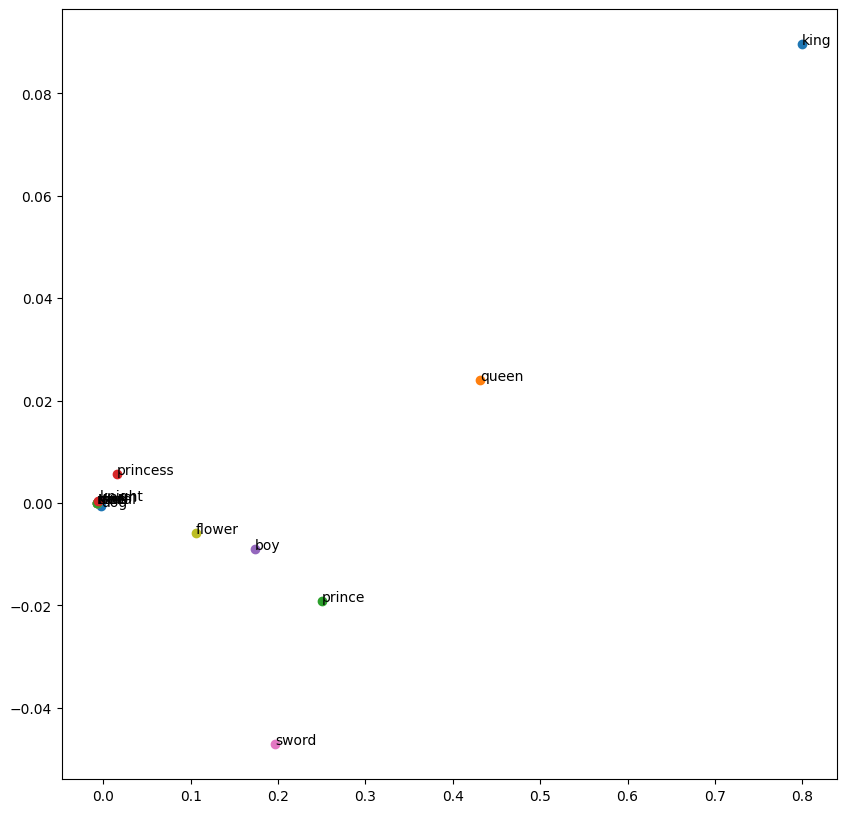

In [271]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 10))

for word in words:
  coord = reduced_embeddings[unique_dict[word]]
  plt.scatter(coord[0], coord[1])
  plt.annotate(word, (coord[0], coord[1]))

plt.savefig('embeddings.png')
